# Apple Stock Price Prediction (AAPL)
This notebook predicts **next-day Adjusted Close** using classic ML regressors.

Key fixes:
- Time-series split (no random split)
- No backfill (prevents leakage)
- Features use only past information (shifted rolling stats)
- Clear target definition (next-day price)


## 1. Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math


## 2. Load data and inspect data

In [ ]:
df = pd.read_csv("AppleStock.csv")

# Clean column names (some files contain non-breaking spaces)
df.columns = [c.strip().replace('\xa0','') for c in df.columns]

print(df.shape)
display(df.head())
print(df.columns)


## 3. Clean Data (nulls + duplicates)

In [ ]:
# Parse date
df["Date"] = pd.to_datetime(df["Date"], format="%d-%b-%y", errors="coerce")

# Convert numeric columns
for col in ["Open", "High", "Low", "Close", "Adj Close"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Volume contains commas
df["Volume"] = pd.to_numeric(df["Volume"].astype(str).str.replace(",", "", regex=False), errors="coerce")

print("Missing values per column:")
print(df.isna().sum())

print("\nDuplicate rows:", df.duplicated().sum())

# Drop rows missing core fields (safe for time-series)
df = df.dropna(subset=["Date","Open","High","Low","Close","Adj Close","Volume"]).copy()

# Sort by date
df = df.sort_values("Date").reset_index(drop=True)

print("\nAfter cleaning:", df.shape)
display(df.head())


## 4. Analyze data with necessary figures

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Adj Close"])
plt.title("AAPL Adjusted Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["Volume"])
plt.title("AAPL Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))

# High-Low range as vertical lines
plt.vlines(df["Date"], df["Low"], df["High"], alpha=0.3)

# Adj Close as line
plt.plot(df["Date"], df["Adj Close"], linewidth=1)

plt.title("AAPL Daily Price Range (High-Low) + Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


## 5. Prepare Target and features

In [ ]:
data = df.copy()

# Returns
data["Return"] = data["Adj Close"].pct_change()
data["Lag1_Return"] = data["Return"].shift(1)
data["Lag2_Return"] = data["Return"].shift(2)

# Rolling statistics (shifted to avoid leakage)
for w in [5, 10, 20]:
    data[f"RollMean_{w}"] = data["Adj Close"].rolling(w).mean().shift(1)
    data[f"RollStd_{w}"]  = data["Adj Close"].rolling(w).std().shift(1)

# Target: next-day adjusted close
data["Target"] = data["Adj Close"].shift(-1)

# Drop rows with NaNs from rolling/shift
data = data.dropna().reset_index(drop=True)

feature_cols = [
    "Open","High","Low","Adj Close","Volume",
    "Lag1_Return","Lag2_Return",
    "RollMean_5","RollStd_5",
    "RollMean_10","RollStd_10",
    "RollMean_20","RollStd_20"
]

X = data[feature_cols].values
y = data["Target"].values

print("Dataset for modeling:", data.shape)
display(data[["Date","Adj Close","Target"]].head())


## 6. Split data into training and testing sets (time-based 80/20)

In [ ]:
split_idx = int(len(data) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_test = data["Date"].iloc[split_idx:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)


## 7. Train Linear Regression, KNN, SVR

In [ ]:
models = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=10))
    ]),
    "SVR": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(kernel="rbf", C=100, gamma="scale", epsilon=0.1))
    ])
}

preds = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds[name] = pipe.predict(X_test)

print("Training complete.")


## 8. Evaluate models (MAE, RMSE, R-squared)

In [ ]:
results = []

for name, y_pred in preds.items():
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(results, columns=["Model","MAE","RMSE","R2"]).sort_values("RMSE")
display(results_df)


In [ ]:
# Metrics comparison (MAE / RMSE / R2) ----
# a: MAE by Model 
metrics_plot = results_df.set_index("Model")[["MAE", "RMSE", "R2"]]

plt.figure(figsize=(6, 4))
metrics_plot["MAE"].plot(kind="bar")
plt.title("MAE by Model")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()


# b: RMSE by Model 
plt.figure(figsize=(6, 4))
metrics_plot["RMSE"].plot(kind="bar")
plt.title("RMSE by Model")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()


# c: R² by Model
plt.figure(figsize=(6, 4))
metrics_plot["R2"].plot(kind="bar")
plt.title("R² by Model")
plt.ylabel("R²")
plt.tight_layout()
plt.show()


In [ ]:
best_model_name = results_df.iloc[0]["Model"]
best_pred = preds[best_model_name]
residuals = y_test - best_pred

plt.figure(figsize=(6, 6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.title(f"Actual vs Predicted Scatter ({best_model_name})")
plt.xlabel("Actual Next-day Adj Close")
plt.ylabel("Predicted Next-day Adj Close")
plt.tight_layout()
plt.show()


In [ ]:
#  Feature correlation heatmap
corr = data[feature_cols + ["Target"]].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, aspect="auto", cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)

# add numbers inside each cell
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        plt.text(
            j, i,
            f"{corr.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=8,
            color="black"
        )

plt.title("Correlation Heatmap (Features + Target)")
plt.tight_layout()
plt.show()


## 9. Plot actual vs. predicted values

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test, label="Actual (Next-day Adj Close)")

for name, y_pred in preds.items():
    plt.plot(dates_test, y_pred, label=f"Predicted - {name}", alpha=0.8)

plt.title("Actual vs Predicted Next-day AAPL Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


## 10. Predict future Apple stock prices
Recursive forecasting using the best RMSE model.

Note: future OHLCV values are unknown; this uses placeholders for demonstration.

Best model: Linear Regression
Last available date: 2025-11-20
Predicted next trading day: 2025-11-21
Predicted next-day Adj Close: 266.5399319867792


,Date,Predicted_Adj_Close
0,2025-11-21,266.539932
1,2025-11-24,266.989860
2,2025-11-25,267.405782
3,2025-11-26,267.732234
4,2025-11-27,268.005686
5,2025-11-28,268.179068
6,2025-12-01,268.230883
7,2025-12-02,268.275291
8,2025-12-03,268.318176
9,2025-12-04,268.350177


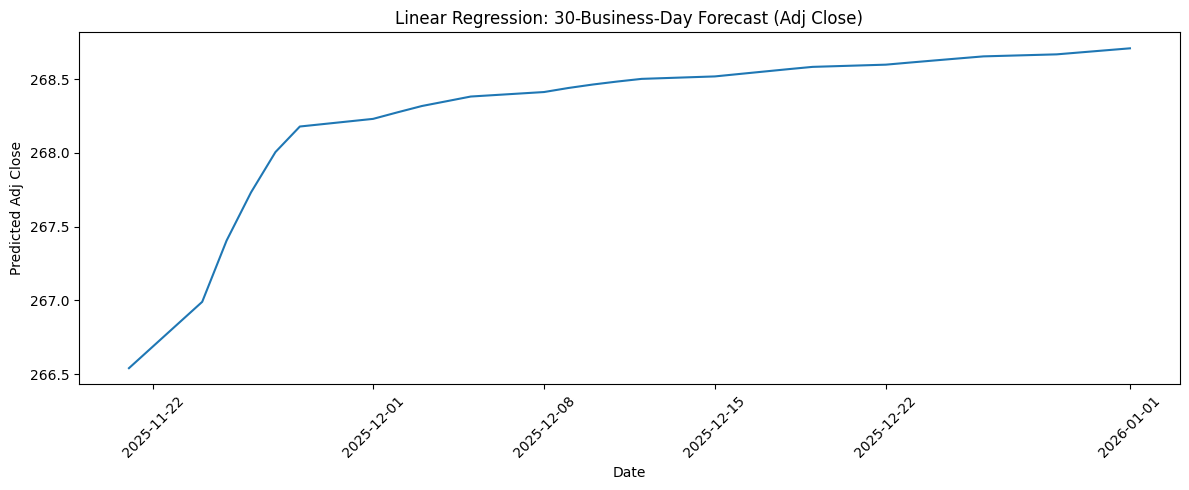

In [22]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

# Train best model on ALL data
best_model.fit(X, y)

# ===== Predict multiple future trading days (User input N, max 50) =====
N = int(input("Enter number of future trading days (N, max 50): ").strip() or 30)
N = min(N, 50)   # limit to 50
future_days = N

from collections import deque
adj_hist = deque(data["Adj Close"].iloc[-25:].tolist(), maxlen=60)

last_date = data.iloc[-1]["Date"]
last_volume = float(data.iloc[-1]["Volume"])

future_dates = []
future_preds = []

current_date = last_date

for i in range(future_days):
    prev_adj = float(adj_hist[-1])

    rollmean_5  = float(np.mean(list(adj_hist)[-5:]))
    rollstd_5   = float(np.std(list(adj_hist)[-5:], ddof=1)) if len(adj_hist) >= 5 else 0.0
    rollmean_10 = float(np.mean(list(adj_hist)[-10:]))
    rollstd_10  = float(np.std(list(adj_hist)[-10:], ddof=1)) if len(adj_hist) >= 10 else 0.0
    rollmean_20 = float(np.mean(list(adj_hist)[-20:]))
    rollstd_20  = float(np.std(list(adj_hist)[-20:], ddof=1)) if len(adj_hist) >= 20 else 0.0

    if len(adj_hist) >= 2:
        ret_today = (adj_hist[-1] - adj_hist[-2]) / adj_hist[-2]
    else:
        ret_today = 0.0

    if len(adj_hist) >= 3:
        ret_yday = (adj_hist[-2] - adj_hist[-3]) / adj_hist[-3]
    else:
        ret_yday = 0.0

    features = np.array([[
        prev_adj, prev_adj, prev_adj, prev_adj,
        last_volume,
        ret_today, ret_yday,
        rollmean_5, rollstd_5,
        rollmean_10, rollstd_10,
        rollmean_20, rollstd_20
    ]])

    next_pred = float(best_model.predict(features)[0])
    current_date = current_date + pd.tseries.offsets.BDay(1)

    future_dates.append(current_date.date())
    future_preds.append(next_pred)

    adj_hist.append(next_pred)

# ===== Print like your screenshot =====
print(f"Best model: {best_model_name}")
print(f"Last available date: {last_date.date()}")
print(f"Predicted next trading day: {future_dates[0]}")
print(f"Predicted next-day Adj Close: {future_preds[0]}")

# Show all future predictions
future_df = pd.DataFrame({"Date": future_dates, "Predicted_Adj_Close": future_preds})
display(future_df)



plt.figure(figsize=(12,5))
plt.plot(future_df["Date"], future_df["Predicted_Adj_Close"])
plt.title(f"{best_model_name}: {future_days}-Business-Day Forecast (Adj Close)")
plt.xlabel("Date")
plt.ylabel("Predicted Adj Close")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
